In [69]:
"""
https://tradingstrategyguides.com/swing-trading-strategies-that-work/

It's based on classic technical indicator called "Bollinger Bands". It's construced as:
- central moving average (MA), which is a simple moving average.
- two other moving averages at a distance of +-2 standard dev. away from the central MA

There are following steps:
#1: Wait for the price to touch the Upper Bollinger Band. It (in theory) means that price is price moving into 
overbought territory. That is - price is relatively too high for given stock and will probably go down.

Step #2: Wait for the price to Break below the Middle Bollinger Bands. Such a move acts as confirmation of the 
shift in market sentiment. In other words - investors realized that stock is overbought and started seeling
(hence price is going down).

Important Note: the "breakout" of the central MA should be so called "Big Bold Breakout Candle". That is
closing price is near the Low Range of the Candlestick. One should sell at the closing price of the Breakout Candle.

This "Breakout Candle" is meant to confirm that there are real sellers, that is: there is an assumption that such a
strong move down indicates actual changed sentiment of sellers rather that just its the "natural" fluctation 
of the price.

Step #4: Set-up "Protective Stop Loss" above the Breakout Candle
As a stop loss high of the entry candle is taken. Rationalities behind it is that during entry move one assumes 
candle as representation of real market sentiment and sellers. If high of this candle is "broken" that is
clear sign that in this case there was no real sellers sentiment shift.

Step #5: Take Profit once we break and close back above the middle Bollinger Bands (central MA)

THAT WAS SHORT TRADE EXAMPLE. FOR LONG TRADES THERE ARE SAME STEPS BUT IN REVERSED ORDER

My personal thought:
- It would be nice to have some sort of expected range of the move. That is - one is setting up stop loss which is 
fine, but at the same time there is no expected range of the move in preferable direction. That makes calculating
reward-to-risk ratio imposibble.
- If one have multiple trades to choose (and properly diversify portfolio) then given strategy gives no clues about
which trade choose. R2R ratio would be helpfull.
- That problem occures not only when we have couple of trades to choose in the same day. One can "loose" future trade
by choosing the one today - which in reality one is not aware of having small R2RR.
- Having method to estimate R2RR and uses it as an additional filter for trades could be good enhacemnet for that
strategy.

""";



"""
"Big Bold Candle" is actually really unclear. In the article it is mentioned that is should have (for short) 
"closing price is near the Low Range of the Candlestic". The thing is that "Low Range" is the thin line below the 
body - it's also called "wick" or "shadow". But in what sense it's big? Closing price may be  near lowest price but 
the whole price range (from high to low - indication of volatility) may be really "small"...
I could not find any canlde formation actually called "big bold...". I think authours could refer to 2 formations
called "Big Black Candle" and "Big White Candle". Thoe are candles with long bodies. 

Big Black Candle - Has an unusually long black body with a wide range between high and low. Prices open near the
high and close near the low. Considered a bearish pattern.

Big White Candle - Has an unusually long white body with a wide range between high and low of the day. Prices open 
near the low and close near the high. Considered a bullish pattern.

The problem with those definitions is - what it means "unusually long (...) body"? How to quantify that? I could
not find anything more specific than adjectives like "long", "big" etc...

I'd say it should be parametrized somewhow... Or taken from distibution of ranges from the past... I imagine 
that "long" candles may be for stocks quite "normal" where for the others they are super rare. 

As a proxy distribution I can take average range and standard deviation in last X days. It may be the same period
I'm taking for moving average or the other. Then I can see how many standard deviations from average given candle's
range is. If it's above certain threshold - consider it as "big".
""";

In [70]:
# built-in
from itertools import islice
import sys
sys.path.insert(0, '/Users/slaw/osobiste/trading')

# 3rd party
import numpy as np
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import scipy.stats as stats

# custom
import gpw_data
import strategies.helpers as helpers
import backtester
import position_size
import results

# to allow zoom plots
%matplotlib notebook  

In [71]:
import importlib
importlib.reload(gpw_data);
importlib.reload(helpers);

In [72]:
gpwdata = gpw_data.GPWData(pricing_data_path='../pricing_data')
wig_20_stocks = gpwdata.load(index='WIG20')

<IPython.core.display.Javascript object>


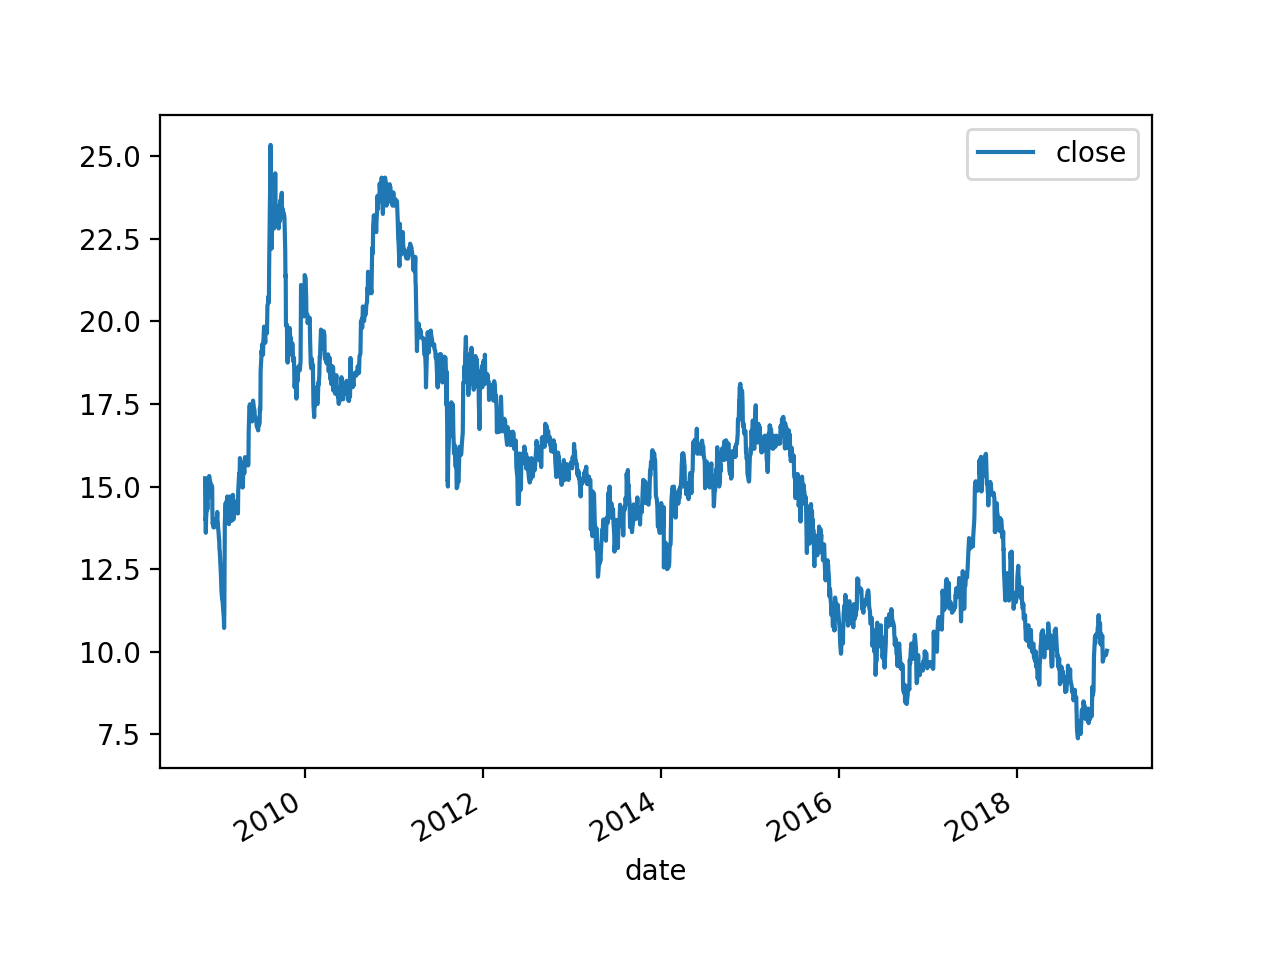

In [73]:
# tests for single stock for now
symbol = wig_20_stocks['ENEA']
# symbol = wig_20_stocks['CCC']
symbol.plot(y=['close']);

In [51]:
def generate_signals(df, ma_type='simple', time_window=20, no_std=2):
    df = df.copy()
    
    # 1) bollinger_bands
    df = helpers.create_bollinger_bands(symbol, ma_type=ma_type, time_window=time_window, no_std=no_std)
    
    # 2) find breakout candles ("Big Bold Candels" from the strategy description)
    # get lenght of clandles body, it's average and std dev
    df.loc[:, 'candle_range'] = abs(df['close'] - df['open'])
    df.loc[:, 'candle_range_avg'] = df['candle_range'].rolling(window=time_window).mean()
    df.loc[:, 'candle_range_std'] = df['candle_range'].rolling(window=time_window).std()
    # identify "long" candles
    df.loc[:, 'is_long'] = abs(df['candle_range_avg'] - df['candle_range']) > no_std*df['candle_range_std']
    
    # 3) # Overbought and oversold regimes
    upper_diff_idx0 = abs(df['upper_ma'].iloc[0] - df['close'].iloc[0])
    lower_diff_idx0 = abs(df['lower_ma'].iloc[0] - df['close'].iloc[0])
    if upper_diff_idx0 >= lower_diff_idx0:
        first_period = 'L'
    elif upper_diff_idx0 < lower_diff_idx0:
        first_period = 'U'
    df.loc[:, 'previous_period'] = np.nan
    df['previous_period'].iloc[0] = first_period
    df.loc[:, 'previous_period'] = np.where(df['close'] <= df['lower_ma'], 'L', df['previous_period'])
    df.loc[:, 'previous_period'] = np.where(df['close'] >= df['upper_ma'], 'U', df['previous_period'])
    df['previous_period'].fillna(method='ffill', inplace=True)
    
    # 4) *for debuging* get first/last dates for Overbought/oversold periods
    overbought = []
    oversold = []
    prev = first_period
    prev_idx_int = 0
    idx_int = 1
    for idx, row in islice(df.iterrows(), 1, None):
        cur = row['previous_period']
        if prev == 'U' and cur == 'L':
            overbought.append((df.index[prev_idx_int], df.index[idx_int-1]))
            prev = cur
            prev_idx_int = idx_int
        elif prev == 'L' and cur == 'U':
            oversold.append((df.index[prev_idx_int], df.index[idx_int-1]))
            prev = cur
            prev_idx_int = idx_int
        if prev == cur:
            idx_int += 1
            continue
        idx_int += 1
        
    # 5) GENERATE ENTRY AND EXIT SIGNALS
    df.loc[:, 'entry_long'] = 0
    df.loc[:, 'entry_short'] = 0
    df.loc[:, 'exit_long'] = 0
    df.loc[:, 'exit_short'] = 0
    df.loc[:, 'stop_loss'] = np.nan
    # helper tracking variable to correctly set up things
    _long_position = 0
    _short_position = 0
    _long_above_cma = 0
    _short_below_cma = 0
    _stop_loss = 0
    for i, row in df.iterrows():
        # entries
        entry_long_signal = (row['is_long'] == True) and (row['close'] > row['open']) and (row['previous_period'] == 'L')
        entry_short_signal = (row['is_long'] == True) and (row['close'] < row['open']) and (row['previous_period'] == 'U')
        if (entry_long_signal == True) and (_long_position == 0):
            df.at[i,'entry_long'] = 1
            _long_position = 1
            _stop_loss = row['low']
        elif (entry_short_signal == True) and (_short_position == 0):
            df.at[i,'entry_short'] = 1
            _short_position = 1
            _stop_loss = row['high']
        # exits
        exit_long_signal = (row['close'] <= row['central_ma']) and _long_above_cma == 1
        exit_short_signal = (row['close'] >= row['central_ma']) and _short_below_cma == 1
        if exit_long_signal and _long_position == 1:
            df.at[i,'exit_long'] = 1
            _long_position = 0
            _long_above_cma = 0
        elif exit_short_signal and _short_position == 1:
            df.at[i,'exit_short'] = 1
            _short_position = 0
            _short_below_cma = 0
        # set up crossing middle central moving average
        if _long_position == 1 and row['close'] > row['central_ma']:
            _long_above_cma = 1
        elif _short_position == 1 and row['open'] < row['central_ma']:
            _short_below_cma = 1
        # roll over stop loss
        if _long_position == 1 or _short_position == 1:
            df.at[i,'stop_loss'] = _stop_loss
            
    # 6) *for debuging* get long and short trades periods
    long_periods, short_periods = helpers.gather_entry_exist_signals_dates(df)
    
    return {
        'df': df,
        'long_periods': long_periods,
        'short_periods': short_periods,
        'overbought_periods': overbought,
        'oversold_periods': oversold,
    }

    
df_with_signals = generate_signals(symbol)
print(df_with_signals['df'].head(28))
    

             open   high    low  close  volume  central_ma    ma_std  \
date                                                                   
2008-12-12  15.00  15.10  15.00  15.06    9074     14.7020  0.524842   
2008-12-15  15.00  15.14  15.00  15.00   18038     14.6895  0.513968   
2008-12-16  15.00  15.00  14.90  15.00   23185     14.7395  0.491512   
2008-12-17  14.97  14.97  14.25  14.25    9286     14.7500  0.477835   
2008-12-18  14.44  14.44  13.76  13.87    6735     14.7635  0.446416   
2008-12-19  13.87  14.13  13.80  13.90    6118     14.7585  0.455877   
2008-12-22  14.00  14.00  13.75  13.76    7423     14.7265  0.502450   
2008-12-23  13.75  13.80  13.60  13.80   21717     14.6915  0.541890   
2008-12-29  13.90  13.90  13.62  13.79   13527     14.6660  0.572422   
2008-12-30  13.83  13.90  13.71  13.89   33524     14.6430  0.594599   
2008-12-31  14.10  14.20  13.90  14.00   19607     14.6120  0.611776   
2009-01-05  14.21  14.21  14.00  14.08    6105     14.5820  0.62

<IPython.core.display.Javascript object>


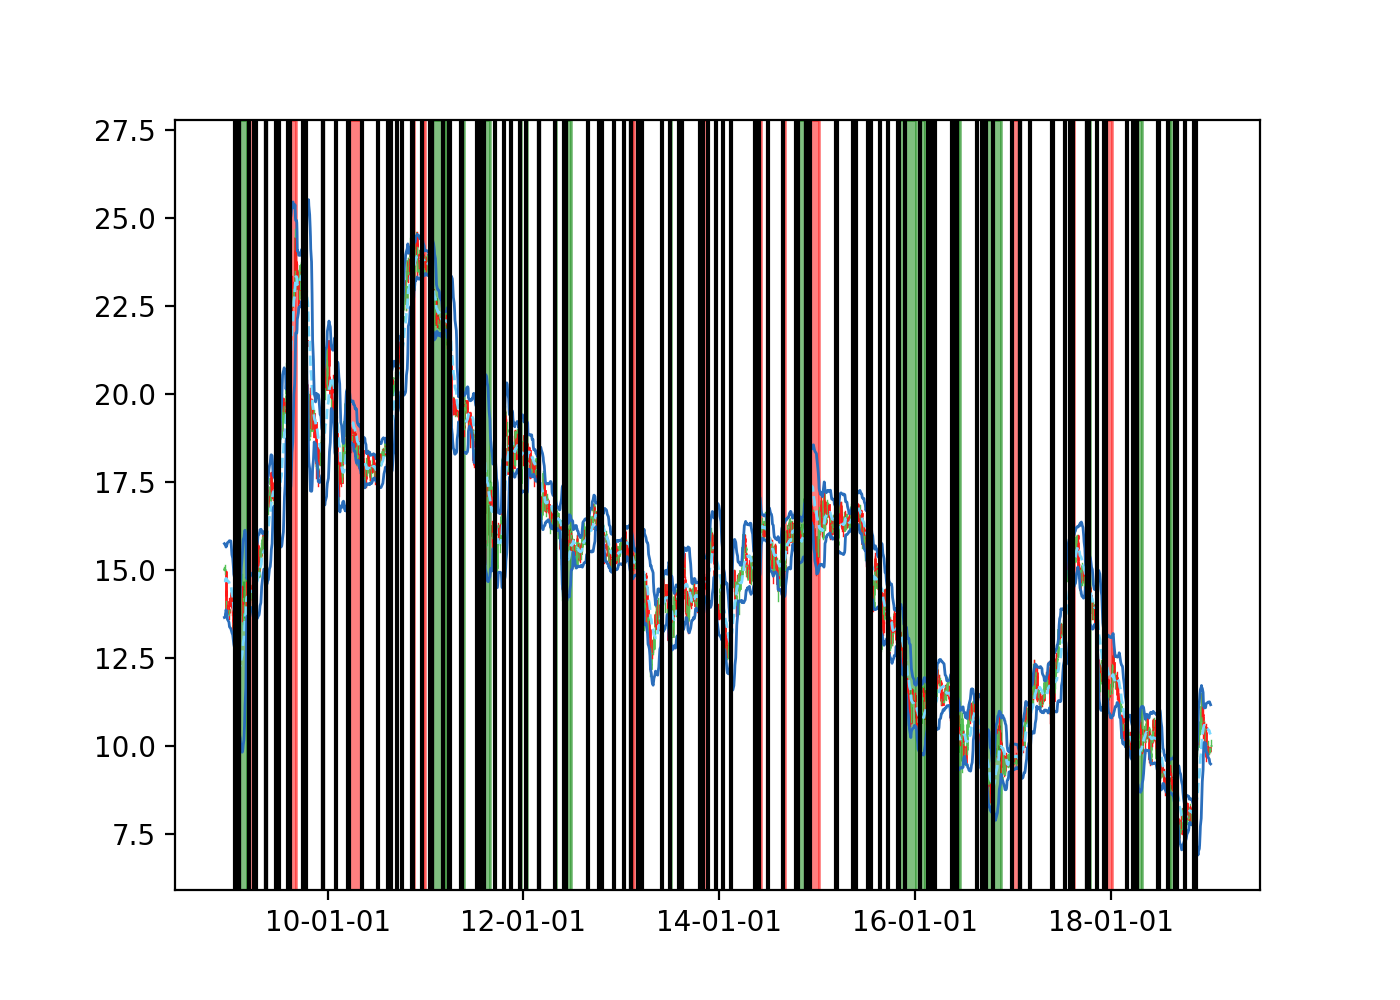

In [74]:
def plot_strategy_signals(
    df=None, ohlc=False, bands=True, close=False, candles=True, long_periods=None, short_periods=None,
    overbought_periods=None, oversold_periods=None
):
    df = df.copy()
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    # candle chart
    if ohlc == True:
        df.loc[:, 'date'] = pd.to_datetime(df.index)
        df.loc[:, 'date'] = df['date'].apply(mdates.date2num)
        df_for_candle = df[['date', 'open', 'high', 'low', 'close']]
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
        candlestick_ohlc(ax, df_for_candle.values, width=.6, colorup='#53c156', colordown='#ff1717')

        # bands, close price and candles
    if bands == True:
        ax.plot(df['central_ma'], color='#7ad9ff', linestyle='--', linewidth=1)
        ax.plot(df['lower_ma'], color='#2a6ebc', linestyle='-', linewidth=1)
        ax.plot(df['upper_ma'], color='#2a6ebc', linestyle='-', linewidth=1)
    if close == True:
        ax.plot(df['close'], color='black', linestyle='-', linewidth=1)
    if candles == True:
        long_candles = df[df['is_long']].index.tolist()
        for c in long_candles:
            ax.axvline(c, color='black', linestyle='-')
    
    # long/short trades periods
    if isinstance(long_periods, list):
        for lp in long_periods:
            ax.axvspan(lp[0], lp[1], alpha=0.5, color='green')
    if isinstance(short_periods, list):
        for sp in short_periods:
            ax.axvspan(sp[0], sp[1], alpha=0.5, color='red')
    
    # overbough and oversold
    if isinstance(overbought_periods, list):
        for obp in overbought_periods:
            ax.axvspan(obp[0], obp[1], alpha=0.5, color='yellow')
    if isinstance(oversold_periods, list):
        for osp in oversold_periods:
            ax.axvspan(osp[0], osp[1], alpha=0.5, color='blue')
    
    plt.show()


plot_strategy_signals(
    df = df_with_signals['df'],
    ohlc = True,
    # candles = False,
    long_periods = df_with_signals['long_periods'],
    short_periods = df_with_signals['short_periods'],
    # overbought_periods = df_with_signals['overbought_periods'],
    # oversold_periods = df_with_signals['oversold_periods'],
)

In [53]:
# rolad modules
importlib.reload(position_size);
importlib.reload(backtester);
importlib.reload(results);

In [75]:
# Test run of the strategy (still without SL)

# prepare data
symbol_key = 'ENEA'
raw_prices = wig_20_stocks[symbol_key]
test_signals = {
    symbol_key: generate_signals(
        raw_prices,
        ma_type='simple',
        time_window=20,
        no_std=2
    )['df']
}
signals_test, signals_validation = gpwdata.split_into_subsets(test_signals, 0.5)
# print(signals_validation)

# run backtester
position_sizer = position_size.MaxFirstEncountered()
tester = backtester.Backtester(test_signals, position_sizer=position_sizer)
tester_results, tester_trades = tester.run()

# calculate results
metrics = results.evaluate(tester_results, tester_trades)

/Users/slaw/osobiste/quantopian_tests/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [76]:
print(metrics)

{'sharpe': -0.7901072659161229, 'max_dd': 84.53859999999999, 'max_dd_duration': 2463, 'annualized_return': -14.316719975431713, 'no_trades': 37, 'expectation': -177.02891891891886}


/Users/slaw/osobiste/quantopian_tests/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


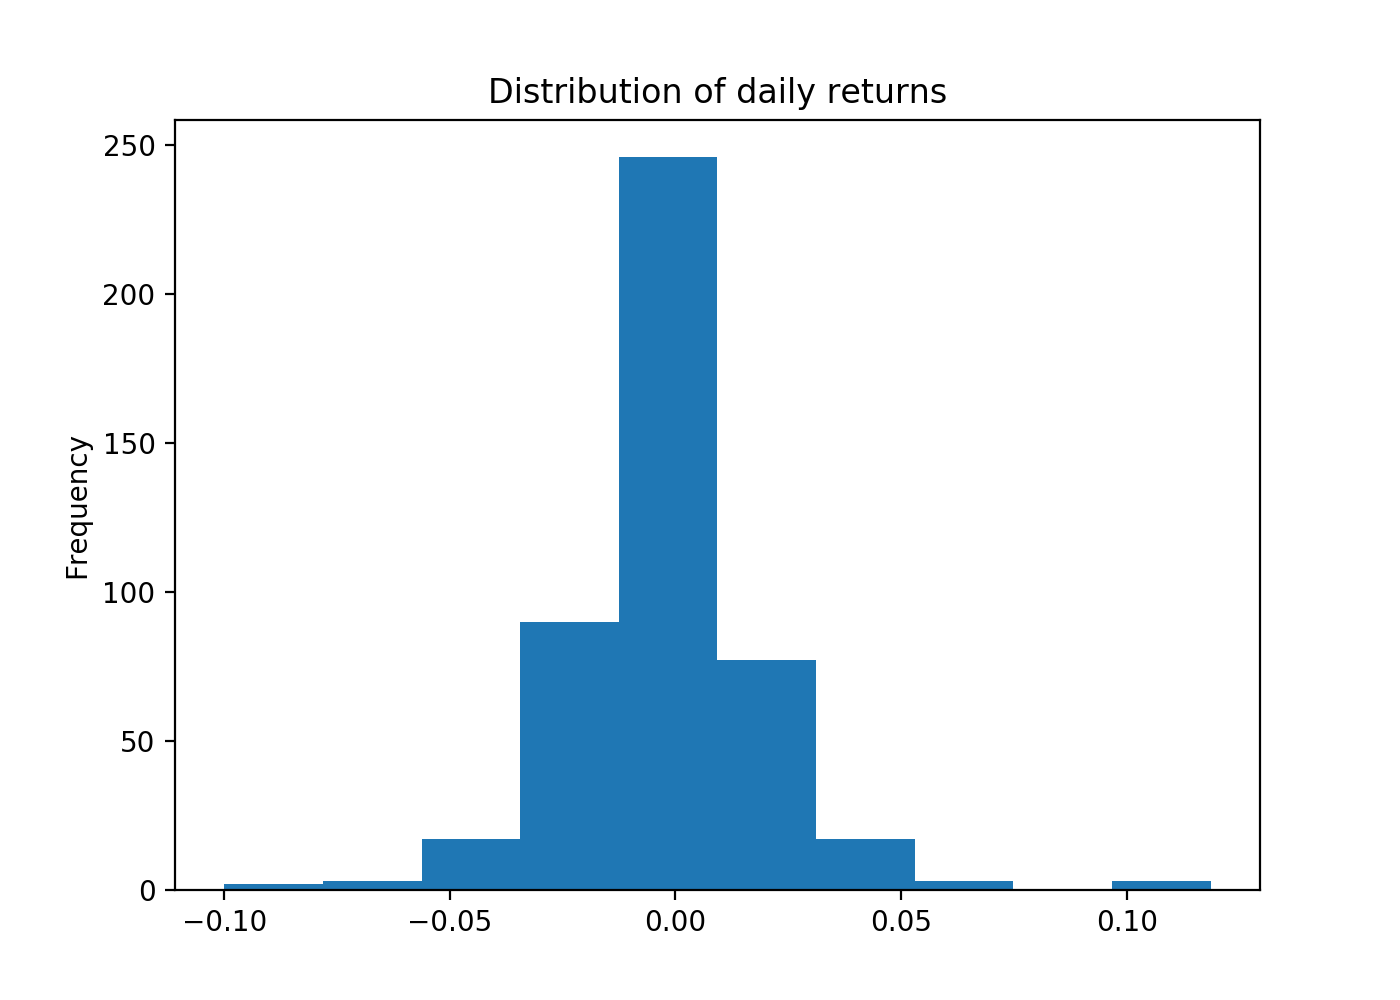

Mean: -0.0020893686783857615
Std Dev: 0.02156938520878869
Excess kurtosis: (would be ~0 for normal): 5.6241656477274
Skewness: 0.5809732623627399


In [118]:
# distribution of daily returns
tester_results.loc[:, 'daily_returns'] = (tester_results['nav']/tester_results['nav'].shift(1)-1)
trunc_res = tester_results[tester_results['daily_returns'] != 0]
trunc_res.dropna(axis=0, inplace=True)

fig_1, ax_1 = plt.subplots(figsize=(7,5))
trunc_res['daily_returns'].plot(ax=ax_1, kind='hist', title='Distribution of daily returns');


trunc_res_arr = trunc_res[trunc_res['daily_returns'] != 0]['daily_returns'].values
# print(xt_arr)

print('Mean: {}'.format(trunc_res_arr.mean()))
print('Std Dev: {}'.format(trunc_res_arr.std()))
print('Excess kurtosis: (would be ~0 for normal): {}'.format(stats.kurtosis(trunc_res_arr)))
print('Skewness: {}'.format(stats.skew(trunc_res_arr)))


<IPython.core.display.Javascript object>


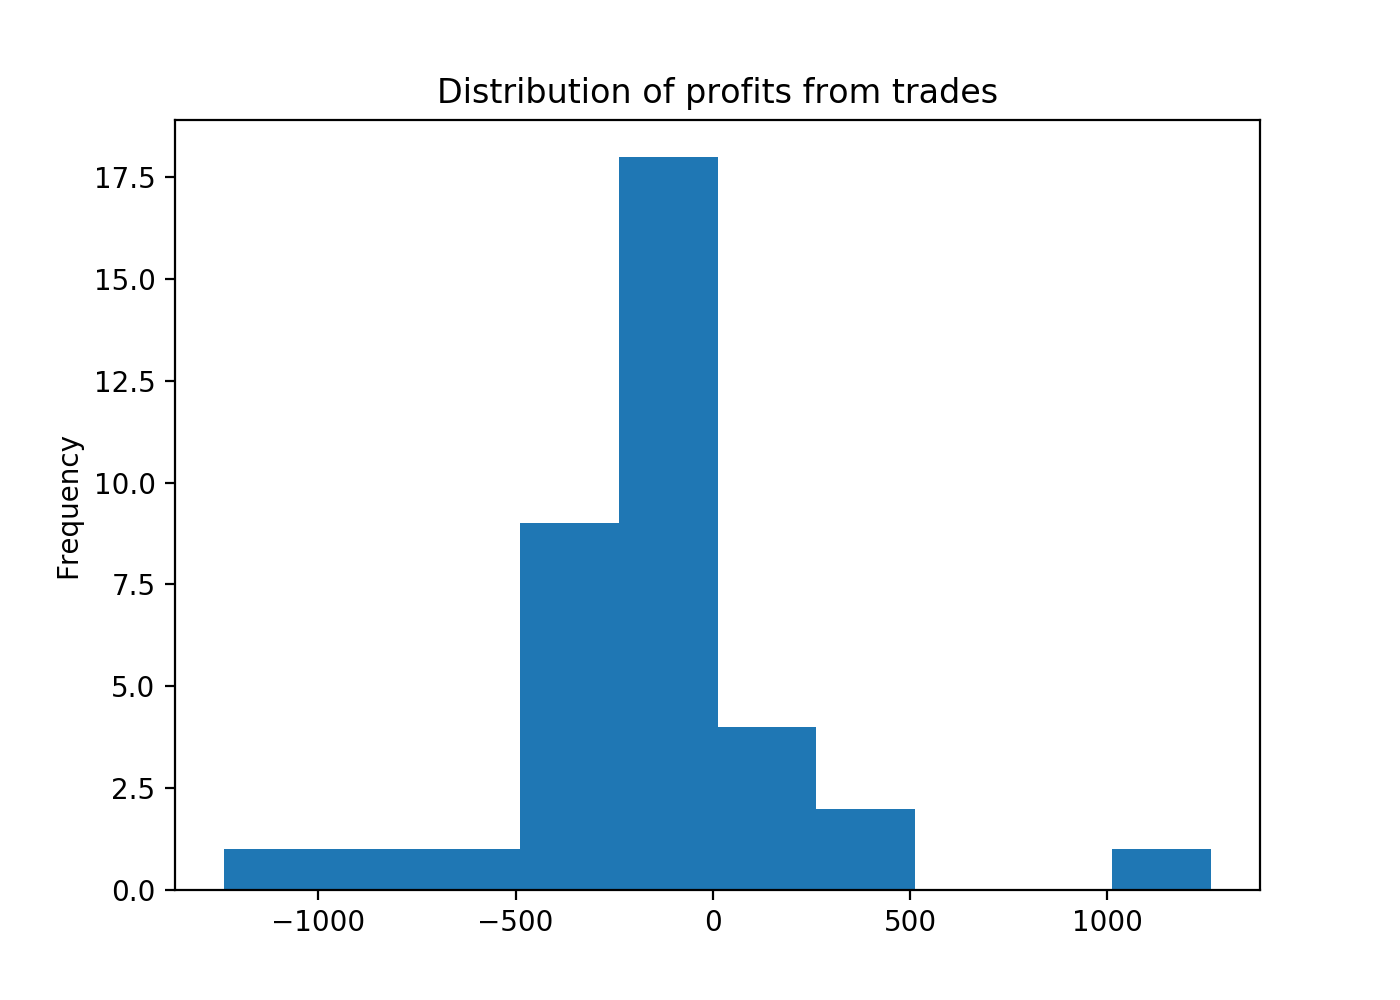

Mean: -177.02891891891892
Std Dev: 368.606895469985
Excess kurtosis: (would be ~0 for normal): 5.7182470803097765
Skewness: 0.9031797935779757


In [119]:
# histogram of profits from trades
profits = {'profit': [t['profit'] for t in tester_trades.values()]} 
profits_df = pd.DataFrame(profits)
profits_arr = profits_df['profit'].values
fig_2, ax_2 = plt.subplots(figsize=(7,5))
profits_df['profit'].plot(ax=ax_2, kind='hist', title='Distribution of profits from trades')

print('Mean: {}'.format(profits_arr.mean()))
print('Std Dev: {}'.format(profits_arr.std()))
print('Excess kurtosis: (would be ~0 for normal): {}'.format(stats.kurtosis(profits_arr)))
print('Skewness: {}'.format(stats.skew(profits_arr)))

In [79]:
"""
TODO;s
OK - clean what you have so far:
OK - visual test performance:
OK - test strategy as it is so far (Stop Loss in not implemented yet)
- better way to assess your results -> POC of raport
- Stop Loss implementation
- how to define Reward-to-risk ration here?
    
Potential improvements (for later):
    -> should SL be taken in signal generation? So that it enters again if entry was premature, SL executed, but then
       proper entry actually lost?
    -> proxiity to overbought oversold area ("close enough")
"""

'\nTODO;s\nOK - clean what you have so far:\nOK - visual test performance:\nOK - test strategy as it is so far (Stop Loss in not implemented yet)\n- better way to assess your results\n- Stop Loss implementation\n- how to define Reward-to-risk ration here?\n    \nPotential improvements (for later):\n    -> should SL be taken in signal generation? So that it enters again if entry was premature, SL executed, but then\n       proper entry actually lost?\n    -> proxiity to overbought oversold area ("close enough")\n'

<IPython.core.display.Javascript object>


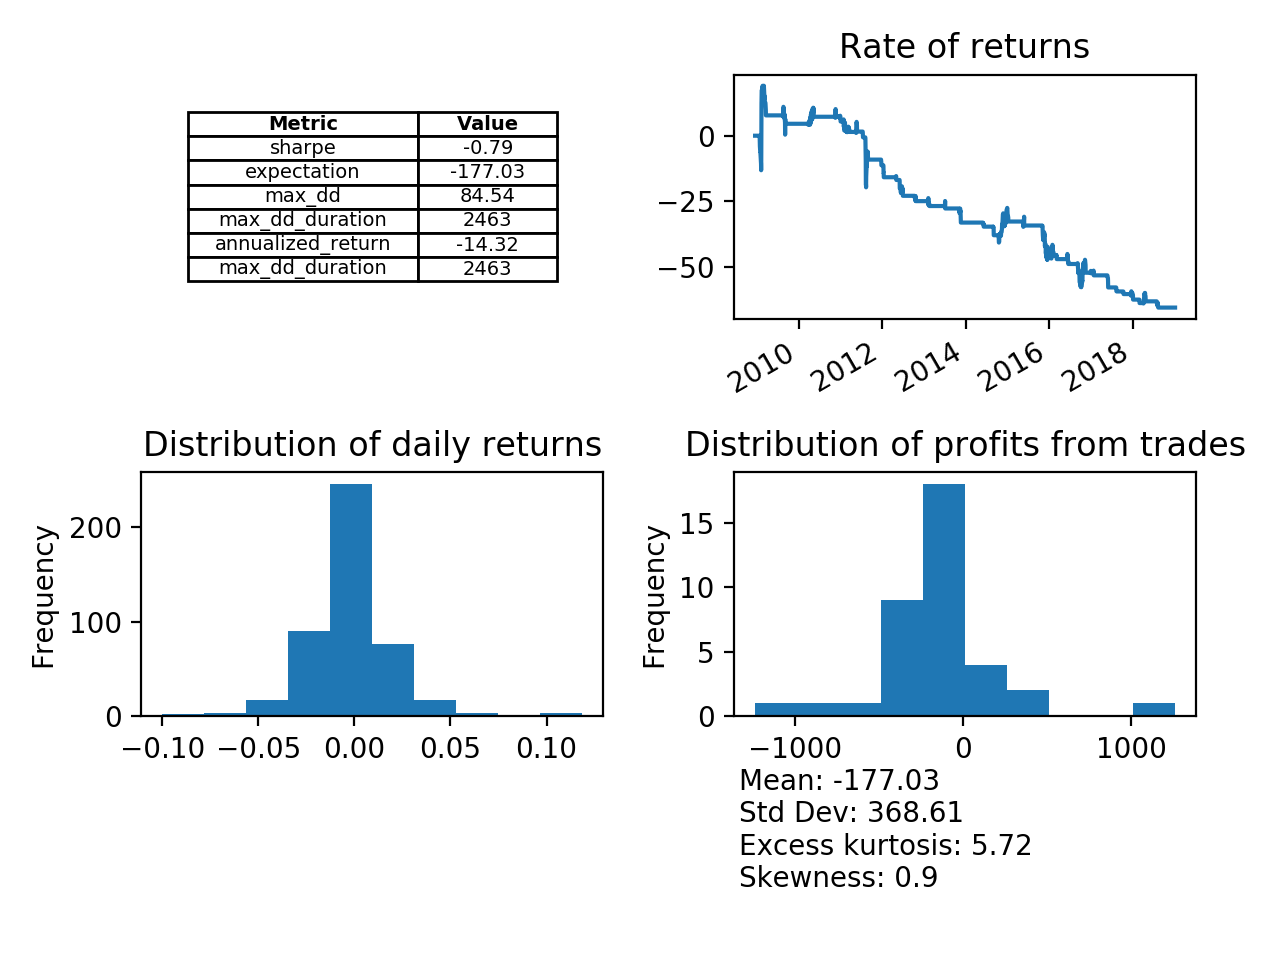

In [188]:
# test for table in matplotlib
from matplotlib.font_manager import FontProperties

fig_3, axes_3 = plt.subplots(nrows=2, ncols=2)

# Draw table with metrics
metrics_labels = ('sharpe', 'expectation', 'max_dd', 'max_dd_duration', 'annualized_return', 'max_dd_duration')
metrics_tbl_ax = axes_3[(0,0)]
metrics_tbl = metrics_tbl_ax.table(
    cellText=[[k, round(metrics[k], 2)] for k in metrics_labels],
    colLabels=['Metric', 'Value'], 
    colWidths=[0.5, 0.3],
    loc='center', 
    cellLoc='center',
)
for (row, col), cell in metrics_tbl.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
metrics_tbl_ax.axis("off")
# metrics_tbl.auto_set_font_size(False)
# metrics_tbl.set_fontsize(14)

# Draw rate of returns curve
tester_results['rate_of_return'].plot(ax=axes_3[(0,1)], title='Rate of returns')

# Draw distribution of daily returns
# TODO(stulski) - missing derivation of trunc_res
trunc_res['daily_returns'].plot(ax=axes_3[(1,0)], kind='hist', title='Distribution of daily returns');

# Draw distribution of trades
# TODO(stulski) - missing derivation of profits_df
profits_df['profit'].plot(ax=axes_3[(1,1)], kind='hist', title='Distribution of profits from trades')

_msg = """
Mean: {}
Std Dev: {}
Excess kurtosis: {}
Skewness: {}
""".format(
    round(profits_arr.mean(), 2),
    round(profits_arr.std(), 2),
    round(stats.kurtosis(profits_arr), 2), 
    round(stats.skew(profits_arr), 2),
)

trades_ax = axes_3[(1,1)]
trades_ax.text(
    0.01, -0.7, _msg.strip(), ha="left", transform=trades_ax.transAxes, # size=12
)

plt.tight_layout();




